C:\Users\USER\AppData\Local\Temp\ipykernel_26252\2779602947.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("lokasi_clean", group_keys=False).apply(reindex_daily)
C:\Users\USER\AppData\Local\Temp\ipykernel_26252\2779602947.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("lokasi_clean", group_keys=False).apply(create_lag)



MACRO F1 VALIDATION: 0.8959

              precision    recall  f1-score   support

        BAIK       0.78      0.91      0.84       381
      SEDANG       0.96      0.95      0.96      2326
 TIDAK SEHAT       0.95      0.84      0.89       320

    accuracy                           0.94      3027
   macro avg       0.90      0.90      0.90      3027
weighted avg       0.94      0.94      0.94      3027



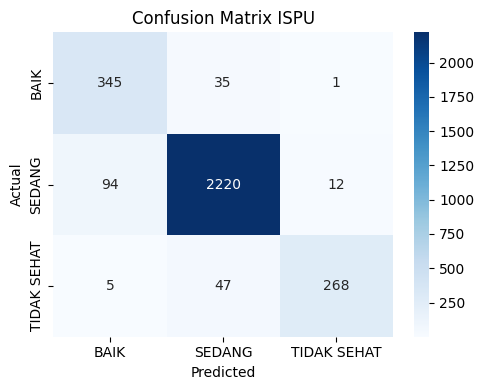

✅ SELESAI — submission_final.csv siap upload


In [1]:
# =========================================================
# FULL PIPELINE SEKALI RUN (READ CSV → TRAIN → EVAL → SUBMIT)
# =========================================================

import pandas as pd
import numpy as np
from pathlib import Path
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# =========================================================
# 1. LOAD DATA
# =========================================================
PATH = Path("merged_libur_cuaca_ispu_ndvi.csv")
df = pd.read_csv(PATH, sep=";")

df["tanggal"] = pd.to_datetime(df["tanggal"], dayfirst=True)
df = df.sort_values(["lokasi_clean", "tanggal"]).reset_index(drop=True)

DROP_COLS = ["max", "parameter_pencemar_kritis", "time", "id", "stasiun"]
df = df.drop(columns=DROP_COLS, errors="ignore")

LABEL_MAP = {"BAIK": 0, "SEDANG": 1, "TIDAK SEHAT": 2}
df = df[df["kategori"].notna()].copy()
df["target"] = df["kategori"].map(LABEL_MAP).astype(int)

# =========================================================
# 2. REINDEX HARIAN
# =========================================================
def reindex_daily(g):
    idx = pd.date_range(g["tanggal"].min(), g["tanggal"].max(), freq="D")
    g = g.set_index("tanggal").reindex(idx)
    g["lokasi_clean"] = g["lokasi_clean"].iloc[0]
    return g.reset_index().rename(columns={"index": "tanggal"})

df = df.groupby("lokasi_clean", group_keys=False).apply(reindex_daily)

# =========================================================
# 3. HANDLE PM2.5
# =========================================================
df["pm25_missing"] = df["pm_duakomalima"].isna().astype(int)

median_pm25 = (
    df[df["tanggal"] >= "2021-01-01"]
    .groupby("lokasi_clean")["pm_duakomalima"]
    .median()
)

df["pm_duakomalima"] = df["pm_duakomalima"].fillna(
    df["lokasi_clean"].map(median_pm25)
)

df = df[df["target"].notna()].copy()

# =========================================================
# 4. TIME FEATURES
# =========================================================
df["month"] = df["tanggal"].dt.month
df["dayofyear"] = df["tanggal"].dt.dayofyear
df["dayofweek"] = df["tanggal"].dt.dayofweek

# =========================================================
# 5. LAG FEATURES
# =========================================================
POLLUTANT_COLS = [
    "pm_sepuluh","pm_duakomalima","ozon",
    "nitrogen_dioksida","sulfur_dioksida","karbon_monoksida"
]

LAGS = [1,2,3]

def create_lag(g):
    g = g.sort_values("tanggal")
    for col in POLLUTANT_COLS:
        for lag in LAGS:
            g[f"{col}_lag{lag}"] = g[col].shift(lag)
    return g

df = df.groupby("lokasi_clean", group_keys=False).apply(create_lag)

df_model = df.dropna(subset=["target"]).reset_index(drop=True)

# =========================================================
# 6. ENCODE LOKASI
# =========================================================
le_loc = LabelEncoder()
df_model["lokasi_enc"] = le_loc.fit_transform(df_model["lokasi_clean"])

# =========================================================
# 7. TEMPORAL SPLIT
# =========================================================
cutoff_date = "2024-01-01"

train_df = df_model[df_model["tanggal"] < cutoff_date]
valid_df = df_model[df_model["tanggal"] >= cutoff_date]

ISPU_FEATURES = POLLUTANT_COLS + ["month","dayofyear","dayofweek","lokasi_enc"]

X_train, y_train = train_df[ISPU_FEATURES], train_df["target"]
X_valid, y_valid = valid_df[ISPU_FEATURES], valid_df["target"]

# =========================================================
# 8. TRAIN MODEL ISPU
# =========================================================
train_data = lgb.Dataset(X_train, label=y_train)

ISPU_PARAMS = {
    "objective": "multiclass",
    "num_class": 3,
    "learning_rate": 0.05,
    "num_leaves": 63,
    "verbosity": -1,
    "seed": 42,
}

ispu_model = lgb.train(ISPU_PARAMS, train_data, num_boost_round=500)

# =========================================================
# 9. THRESHOLD TUNING + EVALUASI
# =========================================================
probs_valid = ispu_model.predict(X_valid)
best_t = [0.33,0.33,0.33]

for c in range(3):
    best_f1 = 0
    for t in np.linspace(0.2,0.6,25):
        pred = probs_valid.argmax(1).copy()
        pred[probs_valid[:,c] > t] = c
        f1 = f1_score(y_valid, pred, average="macro")
        if f1 > best_f1:
            best_f1, best_t[c] = f1, t

pred_valid = probs_valid.argmax(1)
for c,t in enumerate(best_t):
    pred_valid[probs_valid[:,c] > t] = c

macro_f1 = f1_score(y_valid, pred_valid, average="macro")
print(f"\nMACRO F1 VALIDATION: {macro_f1:.4f}\n")

print(classification_report(
    y_valid, pred_valid,
    target_names=["BAIK","SEDANG","TIDAK SEHAT"]
))

# =========================================================
# 10. CONFUSION MATRIX
# =========================================================
cm = confusion_matrix(y_valid, pred_valid)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["BAIK","SEDANG","TIDAK SEHAT"],
            yticklabels=["BAIK","SEDANG","TIDAK SEHAT"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix ISPU")
plt.tight_layout()
plt.show()

# =========================================================
# 11. TRAIN FINAL MODEL (FULL DATA) → SUBMISSION
# =========================================================
full_data = lgb.Dataset(df_model[ISPU_FEATURES], label=df_model["target"])
final_model = lgb.train(ISPU_PARAMS, full_data, num_boost_round=500)

sub = pd.read_csv("sample_submission.csv")
sub["tanggal"] = pd.to_datetime(sub["id"].str.split("_").str[0])
sub["lokasi_clean"] = sub["id"].str.split("_").str[1]
sub["lokasi_enc"] = le_loc.transform(sub["lokasi_clean"])

X_sub = sub[["lokasi_enc"]].copy()
X_sub["month"] = sub["tanggal"].dt.month
X_sub["dayofyear"] = sub["tanggal"].dt.dayofyear
X_sub["dayofweek"] = sub["tanggal"].dt.dayofweek

# pakai nilai polutan terakhir tiap lokasi
last_vals = df_model.groupby("lokasi_clean")[POLLUTANT_COLS].last()

for col in POLLUTANT_COLS:
    X_sub[col] = sub["lokasi_clean"].map(last_vals[col])

probs = final_model.predict(X_sub)
pred = probs.argmax(1)

INV_LABEL_MAP = {0:"BAIK",1:"SEDANG",2:"TIDAK SEHAT"}
sub["kategori"] = [INV_LABEL_MAP[i] for i in pred]

sub[["id","kategori"]].to_csv("submission_final.csv", index=False)

print("✅ SELESAI — submission_final.csv siap upload")
